In [766]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
import pandas as pd
import joblib






In [768]:
# Ensure reproducibility
tf.keras.utils.set_random_seed(313)
tf.config.experimental.enable_op_determinism()


data = pd.read_csv("Dataset/Nino3.4_data.csv")
test_years = pd.read_csv("Dataset/test_years.csv")["year"].values

# Extract all data rows from test year
datatest = data["year"].isin(test_years)
data_test = data[datatest].copy()
data_trainval = data[~datatest].copy()

# creating additional features from the month column，Mapping to 2dimension sine/cosine Periodicity
def add_month_feats(df):
    df = df.copy()
    m = df["month"].values.astype(float)
    df["m_sin"] = np.sin(2*np.pi*m/12.0)
    df["m_cos"] = np.cos(2*np.pi*m/12.0)
    return df

data_trainval = add_month_feats(data_trainval)   
data_test     = add_month_feats(data_test)     



In [770]:
# train 80%  val 20%
train_df, val_df = train_test_split(
    data_trainval, test_size=0.2, random_state=313, shuffle=True
)

features = ["nino_t", "nino_tminus1", "nino_tminus2", "m_sin", "m_cos"]
X_train = train_df[features].to_numpy()
y1_train = train_df["nino_tplus1"].to_numpy()
y2_train = train_df["nino_tplus2"].to_numpy()
y3_train = train_df["nino_tplus3"].to_numpy()
y4_train = train_df["nino_tplus4"].to_numpy()
y5_train = train_df["nino_tplus5"].to_numpy()
y6_train = train_df["nino_tplus6"].to_numpy()

X_val = val_df[features].to_numpy() 
y1_val = val_df["nino_tplus1"].to_numpy()
y2_val = val_df["nino_tplus2"].to_numpy()
y3_val = val_df["nino_tplus3"].to_numpy()
y4_val = val_df["nino_tplus4"].to_numpy()
y5_val = val_df["nino_tplus5"].to_numpy()
y6_val = val_df["nino_tplus6"].to_numpy()


X_test = data_test[features].to_numpy() 
y1_test = data_test["nino_tplus1"].to_numpy()
y2_test = data_test["nino_tplus2"].to_numpy()
y3_test = data_test["nino_tplus3"].to_numpy()
y4_test = data_test["nino_tplus4"].to_numpy()
y5_test = data_test["nino_tplus5"].to_numpy()
y6_test = data_test["nino_tplus6"].to_numpy()

y_mult_train = train_df[["nino_tplus1","nino_tplus2","nino_tplus3",
                          "nino_tplus4","nino_tplus5","nino_tplus6"]].to_numpy()
y_mult_val = val_df[["nino_tplus1","nino_tplus2","nino_tplus3",
                          "nino_tplus4","nino_tplus5","nino_tplus6"]].to_numpy()
y_mult_test = data_test[["nino_tplus1","nino_tplus2","nino_tplus3",
                          "nino_tplus4","nino_tplus5","nino_tplus6"]].to_numpy()

print(f"Train samples: {len(y1_train)}, Validation samples: {len(y1_val)}, Test samples: {len(y1_test)}")




Train samples: 584, Validation samples: 146, Test samples: 72


In [771]:
#Apply scaling transformations to the input features
scaler_X = StandardScaler().fit(X_train)
X_train = scaler_X.transform(X_train)
X_val   = scaler_X.transform(X_val)
X_test  = scaler_X.transform(X_test)
joblib.dump(scaler_X, 'scaler_X.pkl')

def fit_target_scaler(y):
    sc = StandardScaler().fit(y.reshape(-1,1))
    return sc, sc.transform(y.reshape(-1,1))

scaler_y1, y1_train_scaler = fit_target_scaler(y1_train)    
y1_val_scaler = scaler_y1.transform(y1_val.reshape(-1,1))   
scaler_y2, y2_train_scaler = fit_target_scaler(y2_train)   
y2_val_scaler = scaler_y2.transform(y2_val.reshape(-1,1))  
scaler_y3, y3_train_scaler = fit_target_scaler(y3_train)    
y3_val_scaler = scaler_y3.transform(y3_val.reshape(-1,1))  
scaler_y4, y4_train_scaler = fit_target_scaler(y4_train)    
y4_val_scaler = scaler_y4.transform(y4_val.reshape(-1,1))  
scaler_y5, y5_train_scaler = fit_target_scaler(y5_train)   
y5_val_scaler = scaler_y5.transform(y5_val.reshape(-1,1))   
scaler_y6, y6_train_scaler = fit_target_scaler(y6_train)    
y6_val_scaler = scaler_y6.transform(y6_val.reshape(-1,1)) 
joblib.dump(scaler_y1, 'scaler_y1.pkl')
joblib.dump(scaler_y2, 'scaler_y2.pkl')
joblib.dump(scaler_y3, 'scaler_y3.pkl')
joblib.dump(scaler_y4, 'scaler_y4.pkl')
joblib.dump(scaler_y5, 'scaler_y5.pkl')
joblib.dump(scaler_y6, 'scaler_y6.pkl')

scaler_y_mult = StandardScaler().fit(y_mult_train)     
y_mult_train_scaled = scaler_y_mult.transform(y_mult_train)
y_mult_val_scaled   = scaler_y_mult.transform(y_mult_val)
joblib.dump(scaler_y_mult, 'scaler_y_mult.pkl')



['scaler_y_mult.pkl']

In [772]:
# Number of samples to plot
plot_samples = 100

# Neural network
def build_modelA():
    tf.keras.backend.clear_session()
    neuralmodel = Sequential([
        Input(shape=(len(features),)),
        Dense(64,activation='tanh'),
        Dense(16,activation='tanh'),
        Dropout(0.01),
        Dense(1, activation="linear"),
    ])
    neuralmodel.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0005))
    return neuralmodel


def build_modelB():
    tf.keras.backend.clear_session()
    neuralmodel = Sequential([
        Input(shape=(len(features),)),
        Dense(512,activation='tanh'),
        Dense(256,activation='tanh'),
        Dense(64,activation='tanh'),
         Dropout(0.01),
        Dense(6, activation="linear"),
    ])
    neuralmodel.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0005))
    return neuralmodel

# Early stopping on validation loss,
es1 = EarlyStopping(
    monitor="val_loss", mode="min", patience=30, restore_best_weights=True
)
es2 = EarlyStopping(
    monitor="val_loss", mode="min", patience=30, restore_best_weights=True
)
es3 = EarlyStopping(
    monitor="val_loss", mode="min", patience=30, restore_best_weights=True
)
es4 = EarlyStopping(
    monitor="val_loss", mode="min", patience=30, restore_best_weights=True
)
es5 = EarlyStopping(
    monitor="val_loss", mode="min", patience=30, restore_best_weights=True
)
es6 = EarlyStopping(
    monitor="val_loss", mode="min", patience=30, restore_best_weights=True
)

esB = EarlyStopping(
    monitor="val_loss", mode="min", patience=10, restore_best_weights=True
)
esBi = EarlyStopping(
    monitor="val_loss", mode="min", patience=10, restore_best_weights=True
)



In [776]:
# Train model
histories = []

model1 = build_modelA()
history1 = model1.fit(
    X_train,
    y1_train_scaler,
    validation_data=(X_val, y1_val_scaler),
    epochs=100,
    batch_size=32,
    callbacks=[es1],
    verbose=0,
)

model2 = build_modelA()
history2 = model2.fit(
    X_train,
    y2_train_scaler,
    validation_data=(X_val, y2_val_scaler),
    epochs=100,
    batch_size=32,
    callbacks=[es2],
    verbose=0,
)

model3 = build_modelA()
history3 = model3.fit(
    X_train,
    y3_train_scaler,
    validation_data=(X_val, y3_val_scaler),
    epochs=100,
    batch_size=32,
    callbacks=[es3],
    verbose=0,
)

model4 = build_modelA()
history4 = model4.fit(
    X_train,
    y4_train_scaler,
    validation_data=(X_val, y4_val_scaler),
    epochs=100,
    batch_size=32,
    callbacks=[es4],
    verbose=0,
)

model5 = build_modelA()
history5 = model5.fit(
    X_train,
    y5_train_scaler,
    validation_data=(X_val, y5_val_scaler),
    epochs=100,
    batch_size=32,
    callbacks=[es5],
    verbose=0,
)

model6 = build_modelA()
history6 = model6.fit(
    X_train,
    y6_train_scaler,
    validation_data=(X_val, y6_val_scaler),
    epochs=100,
    batch_size=32,
    callbacks=[es6],
    verbose=0,
)

model1.save("model_tplus1.keras")
model2.save("model_tplus2.keras")
model3.save("model_tplus3.keras")
model4.save("model_tplus4.keras")
model5.save("model_tplus5.keras")
model6.save("model_tplus6.keras")

histories = [
    ("Horizon: 1 Month", history1),
    ("Horizon: 2 Months", history2),
    ("Horizon: 3 Months", history3),
    ("Horizon: 4 Months", history4),
    ("Horizon: 5 Months", history5),
    ("Horizon: 6 Months", history6),
]

modelB = build_modelB()
historyB = modelB.fit(
    X_train,
    y_mult_train_scaled,
    validation_data=(X_val, y_mult_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[esB],
    verbose=0,
)
modelB.save("model_taskB.keras")



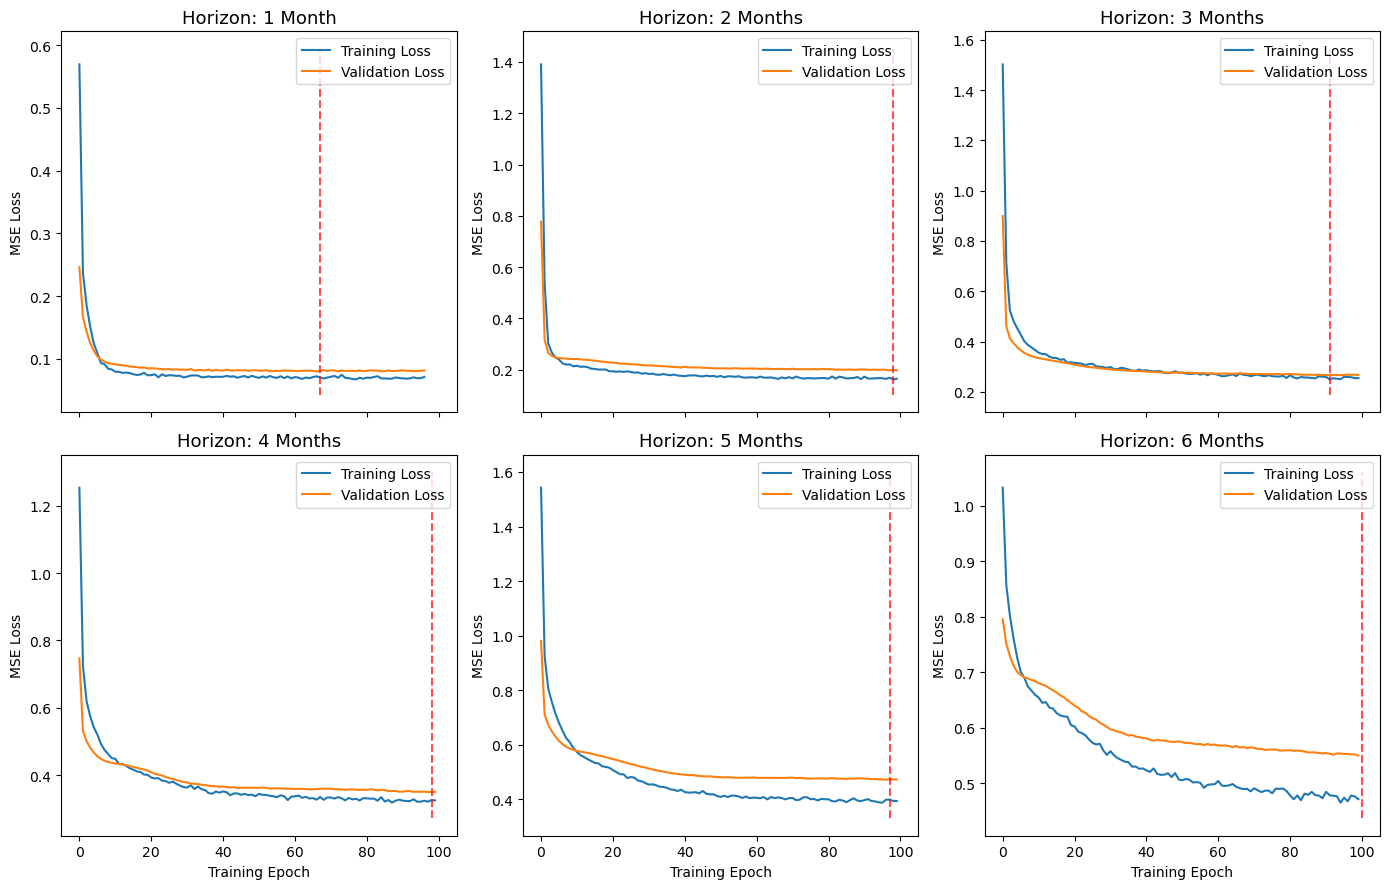

In [777]:
#A plot
fig, axes = plt.subplots(2, 3, figsize=(14, 9), sharex=True)
axes = axes.flatten()

for ax, (title, h) in zip(axes, histories):
    tr = np.array(h.history["loss"])
    vl = np.array(h.history["val_loss"])

    ax.plot(tr, label="Training Loss")        
    ax.plot(vl, label="Validation Loss")

    # min validation loss 
    best_epoch = int(np.argmin(vl)) + 1         
    ymin, ymax = ax.get_ylim()
    ax.vlines(best_epoch, ymin, ymax, linestyles="--", colors="r", alpha=0.7)

    ax.set_title(title, fontsize=13)
    ax.set_ylabel("MSE Loss")

# lable
for ax in axes[3:]:
    ax.set_xlabel("Training Epoch")


for ax in axes:
    ax.legend(loc="upper right", frameon=True)

plt.tight_layout()
plt.show()





-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------


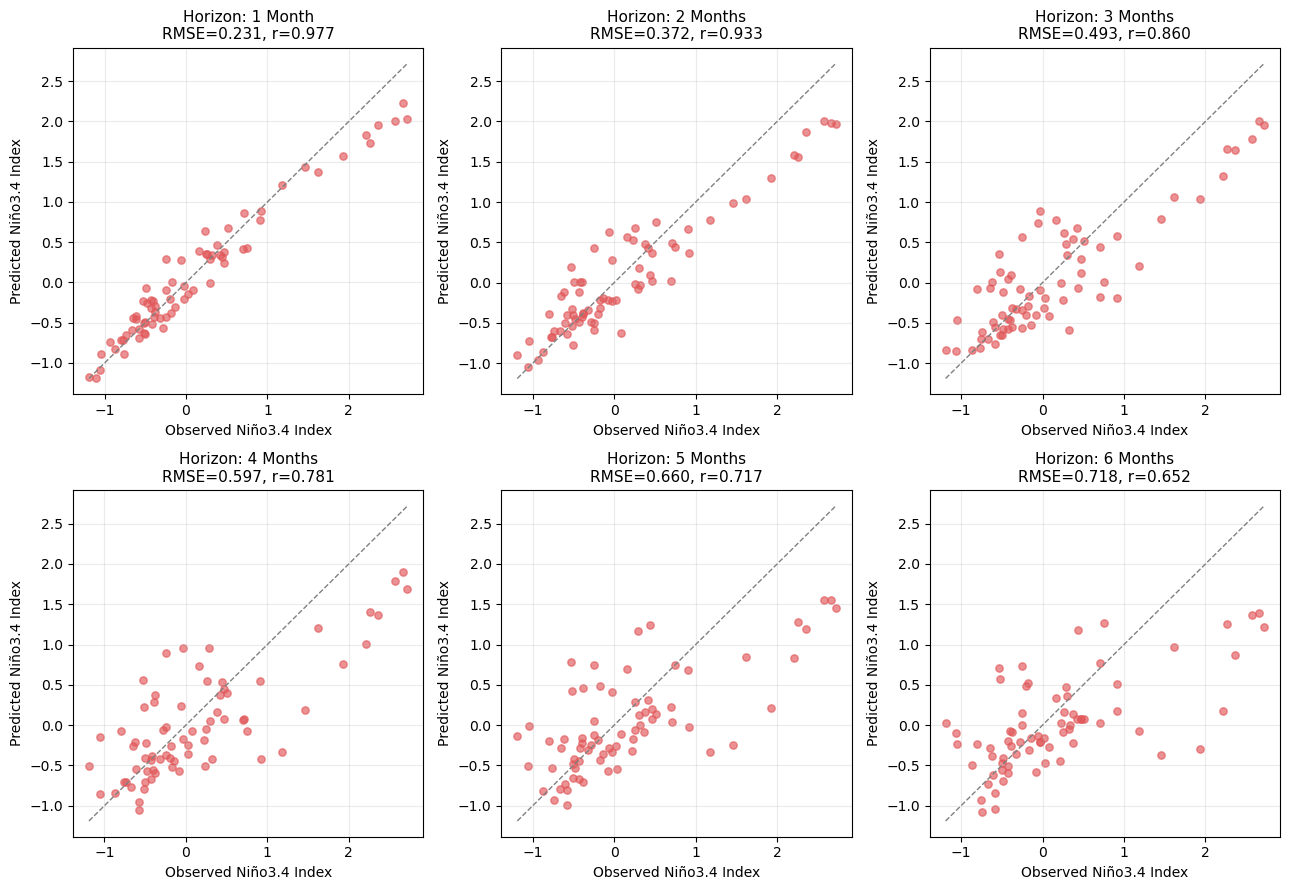

In [778]:
#B plot
print("-" * 115)
print("-" * 115)
y_multi_scaled = modelB.predict(X_test, verbose=0)


y_multi_pred   = scaler_y_mult.inverse_transform(y_multi_scaled) 

y_tests = [y1_test, y2_test, y3_test, y4_test, y5_test, y6_test]
names = ["1 Month", "2 Months", "3 Months", "4 Months", "5 Months", "6 Months"]

fig, axes = plt.subplots(2, 3, figsize=(13, 9))
axes = axes.flatten()

for ax, i in zip(axes, range(6)):
    y_true = y_tests[i]
    y_pred = y_multi_pred[:, i]

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    r = np.corrcoef(y_true, y_pred)[0, 1]

    ax.scatter(y_true, y_pred, s=28, color="#e15759", alpha=0.65)
    lo = min(y_true.min(), y_pred.min()); hi = max(y_true.max(), y_pred.max())
    ax.plot([lo, hi], [lo, hi], "--", color="gray", linewidth=1)
    ax.set_title(f"Horizon: {names[i]}\nRMSE={rmse:.3f}, r={r:.3f}", fontsize=11)
    ax.set_xlabel("Observed Niño3.4 Index")
    ax.set_ylabel("Predicted Niño3.4 Index")
    ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()



In [779]:
print("EVALUATION RESULTS")
print("-" * 40)

# Evaluate Task A models
for horizon in ['tplus1', 'tplus2', 'tplus3', 'tplus4', 'tplus5', 'tplus6']:
    if horizon == 'tplus1':
        model = model1
        scaler_y = scaler_y1
        y_true = y1_test
    elif horizon == 'tplus2':
        model = model2
        scaler_y = scaler_y2
        y_true = y2_test
    elif horizon == 'tplus3':
        model = model3
        scaler_y = scaler_y3
        y_true = y3_test
    elif horizon == 'tplus4':
        model = model4
        scaler_y = scaler_y4
        y_true = y4_test
    elif horizon == 'tplus5':
        model = model5
        scaler_y = scaler_y5
        y_true = y5_test
    elif horizon == 'tplus6':
        model = model6
        scaler_y = scaler_y6
        y_true = y6_test

    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    rmse = np.sqrt(np.mean((y_true - y_pred.ravel()) ** 2))
    corr = np.corrcoef(y_true, y_pred.ravel())[0, 1]

    print(f"{horizon}: RMSE = {rmse:.3f}, Corr = {corr:.3f}")




EVALUATION RESULTS
----------------------------------------
tplus1: RMSE = 0.209, Corr = 0.980
tplus2: RMSE = 0.360, Corr = 0.931
tplus3: RMSE = 0.489, Corr = 0.864
tplus4: RMSE = 0.583, Corr = 0.792
tplus5: RMSE = 0.704, Corr = 0.683
tplus6: RMSE = 0.750, Corr = 0.632


In [780]:
#Model Improvements A Transfer learning improvements
#training tplus1



from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=8,
    min_lr=1e-6,
    verbose=0
)

def build_modelA_transfer():
    model = Sequential([
        Input(shape=(len(features),)),
        Dense(64, activation='elu', name="dense1"),
        Dense(16, activation='elu', name="dense2"),
        Dense(1, activation="linear", name="output")
    ])
    model.compile(loss="mse", optimizer=Adam(learning_rate=1e-3))
    return model

# training t+1
model_tl = build_modelA_transfer()
model_tl.fit(
    X_train, y1_train_scaler,
    validation_data=(X_val, y1_val_scaler),
    epochs=120, batch_size=32, verbose=0,
    callbacks=[reduce_lr]
)


model_tl.compile(loss="mse", optimizer=Adam(learning_rate=1e-4))

# t+2->t+6
for i, (y_tr, y_va) in enumerate([
    (y2_train_scaler, y2_val_scaler),
    (y3_train_scaler, y3_val_scaler),
    (y4_train_scaler, y4_val_scaler),
    (y5_train_scaler, y5_val_scaler),
    (y6_train_scaler, y6_val_scaler)
], start=2):
    model_tl.fit(
        X_train, y_tr,
        validation_data=(X_val, y_va),
        epochs=80, batch_size=32, verbose=0,
        callbacks=[reduce_lr]
    )


model_tl.compile(loss="mse", optimizer=Adam(learning_rate=5e-5))


model_tl.fit(
    X_train, y6_train_scaler,
    validation_data=(X_val, y6_val_scaler),
    epochs=200, batch_size=32, verbose=0,
    callbacks=[reduce_lr]
)


y6_pred_scaled = model_tl.predict(X_test, verbose=0)
y6_pred = scaler_y6.inverse_transform(y6_pred_scaled).ravel()

model_tl.save("model_taskAtplus6.keras")


rmse = np.sqrt(np.mean((y6_test - y6_pred)**2))
r = np.corrcoef(y6_test, y6_pred)[0, 1]

print(f"Transfer Learning tplus1 → tplus6: RMSE={rmse:.3f}, Corr={r:.3f}")


Transfer Learning tplus1 → tplus6: RMSE=0.735, Corr=0.655


In [781]:
#Model Improvements B(gives different weights)
def weighted_mse(weights):
    weights = K.constant(weights, dtype='float32')
    weights = weights / K.sum(weights) 
    def loss(y_true, y_pred):
        se = K.square(y_true - y_pred)      
        weighted_se = se * weights         
        return K.mean(K.sum(weighted_se, axis=1)) 
    return loss
def build_modelB_improved():
    tf.keras.backend.clear_session()
    modelB_imp = Sequential([
        Input(shape=(len(features),)),
        Dense(512,activation='tanh'),
        Dense(256,activation='tanh'),
        Dense(64,activation='tanh'),
        Dense(6, activation="linear"),
    ])
    modelB_imp.compile(
        loss=weighted_mse([1.0, 0.8, 0.7, 0.4, 0.3, 0.3]),
        # loss=weighted_mse([1.0, 1.0, 1.25, 1.5, 1.5, 2.0]),
        optimizer=Adam(learning_rate=0.0005)
    )
    return modelB_imp
modelB_improved = build_modelB_improved()
historyB_improved = modelB_improved.fit(
    X_train, y_mult_train_scaled,
    validation_data=(X_val, y_mult_val_scaled),
    epochs=100, batch_size=16,
    callbacks=[esBi],
    verbose=0
)
y_multi_scaled_imp = modelB_improved.predict(X_test, verbose=0)
y_multi_pred_imp = scaler_y_mult.inverse_transform(y_multi_scaled_imp)
modelB_improved.save("model_taskB_improved.keras")
print("IMPROVED MODEL B")

for i, name in enumerate(["1", "2", "3", "4", "5", "6"]):
    y_true = y_mult_test[:, i]
    y_pred = y_multi_pred_imp[:, i]
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    r = np.corrcoef(y_true, y_pred)[0, 1]
    print(f"Horizon {name} Month: RMSE={rmse:.3f}, Corr={r:.3f}")




IMPROVED MODEL B
Horizon 1 Month: RMSE=0.183, Corr=0.983
Horizon 2 Month: RMSE=0.353, Corr=0.929
Horizon 3 Month: RMSE=0.479, Corr=0.866
Horizon 4 Month: RMSE=0.640, Corr=0.755
Horizon 5 Month: RMSE=0.656, Corr=0.730
Horizon 6 Month: RMSE=0.714, Corr=0.664



=== Performance Comparison Table (Task A vs Task B) ===
Horizon  TaskA_RMSE  TaskB_std_RMSE  TaskB_imp_RMSE  TaskA_Corr  TaskB_std_Corr  TaskB_imp_Corr  Imp_vs_Std_RMSE(%)  Imp_vs_Std_Corr(%)
    t+1       0.209           0.231           0.183       0.980           0.977           0.983              21.131               0.680
    t+2       0.360           0.372           0.353       0.931           0.933           0.929               5.067              -0.438
    t+3       0.489           0.493           0.479       0.864           0.860           0.866               2.812               0.638
    t+4       0.583           0.597           0.640       0.792           0.781           0.755              -7.196              -3.298
    t+5       0.704           0.660           0.656       0.683           0.717           0.730               0.616               1.832
    t+6       0.750           0.718           0.714       0.632           0.652           0.664               0.513            

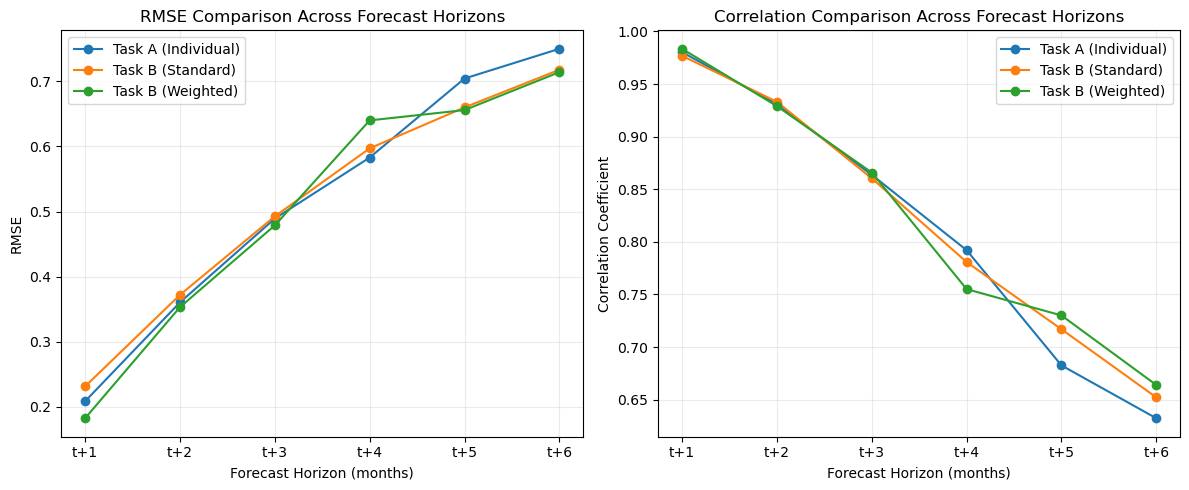

In [782]:
# Evaluate Task models
# ... your evaluation code ...
def rmse_corr(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    return rmse, corr

# 1) Task A（
taskA_preds = []
taskA_metrics_rmse, taskA_metrics_corr = [], []
A_models  = [model1, model2, model3, model4, model5, model6]
A_scalers = [scaler_y1, scaler_y2, scaler_y3, scaler_y4, scaler_y5, scaler_y6]
y_tests   = [y1_test,  y2_test,  y3_test,  y4_test,  y5_test,  y6_test]
for m, sc, y_true in zip(A_models, A_scalers, y_tests):
    y_scaled = m.predict(X_test, verbose=0)
    y_pred   = sc.inverse_transform(y_scaled).ravel()
    r1, r2 = rmse_corr(y_true, y_pred)
    taskA_metrics_rmse.append(r1); taskA_metrics_corr.append(r2)
    taskA_preds.append(y_pred)

#Task B standard
yB_scaled = modelB.predict(X_test, verbose=0)
yB_pred   = scaler_y_mult.inverse_transform(yB_scaled)
taskB_std_rmse, taskB_std_corr = [], []
for i in range(6):
    r1, r2 = rmse_corr(y_tests[i], yB_pred[:, i])
    taskB_std_rmse.append(r1); taskB_std_corr.append(r2)

#Task B improve
yBi_scaled = modelB_improved.predict(X_test, verbose=0)
yBi_pred   = scaler_y_mult.inverse_transform(yBi_scaled)
taskB_imp_rmse, taskB_imp_corr = [], []
for i in range(6):
    r1, r2 = rmse_corr(y_tests[i], yBi_pred[:, i])
    taskB_imp_rmse.append(r1); taskB_imp_corr.append(r2)

#comparison table
horizons = [f"t+{i}" for i in range(1,7)]
df = pd.DataFrame({
    "Horizon": horizons,
    "TaskA_RMSE": taskA_metrics_rmse,
    "TaskB_std_RMSE": taskB_std_rmse,
    "TaskB_imp_RMSE": taskB_imp_rmse,
    "TaskA_Corr": taskA_metrics_corr,
    "TaskB_std_Corr": taskB_std_corr,
    "TaskB_imp_Corr": taskB_imp_corr,
})

# relative improvement
df["Imp_vs_Std_RMSE(%)"] = (np.array(taskB_std_rmse) - np.array(taskB_imp_rmse)) / np.array(taskB_std_rmse) * 100.0
df["Imp_vs_Std_Corr(%)"] = (np.array(taskB_imp_corr) - np.array(taskB_std_corr)) / np.array(taskB_std_corr) * 100.0

# avg_row
avg_row = pd.DataFrame({
    "Horizon": ["Average"],
    "TaskA_RMSE": [np.mean(taskA_metrics_rmse)],
    "TaskB_std_RMSE": [np.mean(taskB_std_rmse)],
    "TaskB_imp_RMSE": [np.mean(taskB_imp_rmse)],
    "TaskA_Corr": [np.mean(taskA_metrics_corr)],
    "TaskB_std_Corr": [np.mean(taskB_std_corr)],
    "TaskB_imp_Corr": [np.mean(taskB_imp_corr)],
    "Imp_vs_Std_RMSE(%)": [np.mean(df["Imp_vs_Std_RMSE(%)"])],
    "Imp_vs_Std_Corr(%)": [np.mean(df["Imp_vs_Std_Corr(%)"])],
})
df_out = pd.concat([df, avg_row], ignore_index=True)

print("\n=== Performance Comparison Table (Task A vs Task B) ===")
print(df_out.round(3).to_string(index=False))
plt.figure(figsize=(12,5))

# left plot
plt.subplot(1,2,1)
plt.plot(horizons, taskA_metrics_rmse, marker="o", label="Task A (Individual)")
plt.plot(horizons, taskB_std_rmse,   marker="o", label="Task B (Standard)")
plt.plot(horizons, taskB_imp_rmse,   marker="o", label="Task B (Weighted)")
plt.title("RMSE Comparison Across Forecast Horizons")
plt.xlabel("Forecast Horizon (months)")
plt.ylabel("RMSE")
plt.legend()
plt.grid(alpha=0.25)

# right plot
plt.subplot(1,2,2)
plt.plot(horizons, taskA_metrics_corr, marker="o", label="Task A (Individual)")
plt.plot(horizons, taskB_std_corr,     marker="o", label="Task B (Standard)")
plt.plot(horizons, taskB_imp_corr,     marker="o", label="Task B (Weighted)")
plt.title("Correlation Comparison Across Forecast Horizons")
plt.xlabel("Forecast Horizon (months)")
plt.ylabel("Correlation Coefficient")
plt.legend()
plt.grid(alpha=0.25)

plt.tight_layout()
plt.show()




In [787]:
# Example evaluation structure (adapt to your implementation)
hidden_data = pd.read_csv("Nino3.4_data_hidden.csv")
hidden_df = add_month_feats(hidden_data)
X_hid = hidden_df[features].to_numpy()
y_hid = hidden_df[["nino_tplus1","nino_tplus2","nino_tplus3",
                       "nino_tplus4","nino_tplus5","nino_tplus6"]].to_numpy()
# load scaler
scaler_X   = joblib.load("scaler_X.pkl")
scaler_y1_  = joblib.load("scaler_y1.pkl")
scaler_y2  = joblib.load("scaler_y2.pkl")
scaler_y3  = joblib.load("scaler_y3.pkl")
scaler_y4  = joblib.load("scaler_y4.pkl")
scaler_y5  = joblib.load("scaler_y5.pkl")
scaler_y6  = joblib.load("scaler_y6.pkl")
scaler_y_mult = joblib.load("scaler_y_mult.pkl")
X_hid_scaled = scaler_X.transform(X_hid)
#load model
modelA_paths = [
    "model_tplus1.keras","model_tplus2.keras","model_tplus3.keras",
    "model_tplus4.keras","model_tplus5.keras","model_tplus6.keras"
]
modelsA_hidden = [load_model(p) for p in modelA_paths]
modelA_improve_hidden  = load_model("model_taskAtplus6.keras")
modelB_hidden  = load_model("model_taskB.keras")
modelB_improve_hidden  = load_model("model_taskB_improved.keras", compile=False)
def _rmse_corr(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    return rmse, corr
taskA_models  = [model1, model2, model3, model4, model5, model6]
taskA_scalers = [scaler_y1, scaler_y2, scaler_y3, scaler_y4, scaler_y5, scaler_y6]
taskA_ytrue   = [y1_test,  y2_test,  y3_test,  y4_test,  y5_test,  y6_test]
for i, (m, sc, y_true) in enumerate(zip(taskA_models, taskA_scalers, taskA_ytrue), start=1):
    y_pred = sc.inverse_transform(m.predict(X_test, verbose=0)).ravel()
    rmse, r = _rmse_corr(y_true, y_pred)
    print(f"tplus{i}: RMSE = {rmse:.3f}, Corr = {r:.3f}")
#Transfer Learning result (A improve)
rmse_tl, r_tl = _rmse_corr(y6_test, y6_pred)
print(f"Transfer Learning tplus1 → tplus6: RMSE={rmse_tl:.3f}, Corr={r_tl:.3f}")

print("Task B")
yB_scaled = modelB.predict(X_test, verbose=0)
yB_pred   = scaler_y_mult.inverse_transform(yB_scaled)
for i in range(6):
    rmse_i, r_i = _rmse_corr(y_mult_test[:, i], yB_pred[:, i])
    print(f"t+{i+1}: RMSE={rmse_i:.3f}, Corr={r_i:.3f}")

#Improved Task B: 1–6 month horizons
print("Improved Model B")
y_multi_scaled_imp = modelB_improved.predict(X_test, verbose=0)
y_multi_pred_imp   = scaler_y_mult.inverse_transform(y_multi_scaled_imp)
for i in range(6):
    rmse_i, r_i = _rmse_corr(taskA_ytrue[i], y_multi_pred_imp[:, i])
    print(f"Horizon {i+1} Month: RMSE={rmse_i:.3f}, Corr={r_i:.3f}")

tplus1: RMSE = 0.209, Corr = 0.980
tplus2: RMSE = 0.360, Corr = 0.931
tplus3: RMSE = 0.489, Corr = 0.864
tplus4: RMSE = 0.583, Corr = 0.792
tplus5: RMSE = 0.704, Corr = 0.683
tplus6: RMSE = 0.750, Corr = 0.632
Transfer Learning tplus1 → tplus6: RMSE=0.735, Corr=0.655
Task B
t+1: RMSE=0.231, Corr=0.977
t+2: RMSE=0.372, Corr=0.933
t+3: RMSE=0.493, Corr=0.860
t+4: RMSE=0.597, Corr=0.781
t+5: RMSE=0.660, Corr=0.717
t+6: RMSE=0.718, Corr=0.652
Improved Model B
Horizon 1 Month: RMSE=0.183, Corr=0.983
Horizon 2 Month: RMSE=0.353, Corr=0.929
Horizon 3 Month: RMSE=0.479, Corr=0.866
Horizon 4 Month: RMSE=0.640, Corr=0.755
Horizon 5 Month: RMSE=0.656, Corr=0.730
Horizon 6 Month: RMSE=0.714, Corr=0.664
